In [239]:
import numpy as np
import matplotlib.pyplot as plt

In [240]:
class GamblerEnv:
    
    def __init__(self, goal=100, prob_heads=0.5):
        self.goal = goal
        self.prob_heads = prob_heads
        self.prob_tails = 1.0 - prob_heads
        
        self.state_space = list(range(goal + 1))  # 0 to goal
        self.num_states = len(self.state_space)
        self.terminal_states = [0, goal]
        
        self.P = self._build_transition_probabilities()
    
    def get_valid_actions(self, state):
        if state in self.terminal_states:
            return []
        max_stake = min(state, self.goal - state)
        return list(range(1, max_stake + 1))
    
    def _get_transitions(self, state, action):
        """
        Calculate transition probabilities for a specific state-action pair.
        
        Args:
            state: Current capital ($)
            action: Stake amount ($)
            
        Returns:
            List of (probability, next_state, reward, done) tuples
            
        The gambler can experience two outcomes:
        - Heads (prob_heads): Win the stake → capital increases by action
        - Tails (prob_tails): Lose the stake → capital decreases by action
        
        """
        if state in self.terminal_states:
            return [(1.0, state, 0, state in self.terminal_states)]
        
        transitions = []
        
        # Heads outcome: Win the stake
        next_state = state + action
        reward = next_state == self.goal
        done = next_state == self.goal
        transitions.append((self.prob_heads, next_state, reward, done))
        
        # Tails outcome: Lose the stake
        next_state = state - action
        reward = 0
        done = next_state == 0
        transitions.append((self.prob_tails, next_state, reward, done))
        
        return transitions
    
    def _build_transition_probabilities(self):
        """
        Build complete transition probability dictionary for all state-action pairs.
        
        Returns:
            Dictionary P[state][action] = [(prob, next_state, reward, done), ...]
        """
        P = {}
        
        for state in self.state_space:
            P[state] = {}
            valid_actions = self.get_valid_actions(state)
            
            for action in valid_actions:
                P[state][action] = self._get_transitions(state, action)
        
        return P

In [241]:
env = GamblerEnv(goal=100, prob_heads=0.4)

In [242]:
def _calculate_action_values(env, V, state, gamma):
   """
   Calculate the value of all valid actions for a specific state.
   
   Args:
       env: Environment instance
       V: Value function array
       state: State index
       gamma: Discount factor
   
   Returns:
       action_values: List of action values for all valid actions in the state,
                     or empty list if state is terminal or has no valid actions
   """


   action_values = []
   valid_actions = env.get_valid_actions(state)
   
   for action in valid_actions:
       action_value = 0
       for prob, next_state, reward, done in env.P[state][action]:
           action_value += prob * (reward + gamma * V[next_state])
       action_values.append(action_value)
   
   return action_values

def _extract_greedy_policy(env, V, gamma):
   """
   Extract the greedy policy from a given value function by selecting
   the action with highest value in each state.
   
   Args:
       env: Environment instance
       V: Value function array
       gamma: Discount factor
   
   Returns:
       policy: 1D numpy array where policy[s] is the greedy action for state s.
               For states with no valid actions, policy[s] = 0.
   """
   policy = np.zeros(env.num_states, dtype=int)
   
   for state in range(env.num_states):
       valid_actions = env.get_valid_actions(state)

       if not valid_actions:
           policy[state] = 0
           continue
       
       action_values = _calculate_action_values(env, V, state, gamma)
       action_values = np.around(action_values, 5)
       best_action_idx = np.argmax(action_values) 
       policy[state] = valid_actions[best_action_idx]
   
   return policy

In [243]:
def value_iteration(env, gamma=1.0, theta=1e-4, track_iters=None, in_place=True):
    """
    Solve the Gambler's Problem using value iteration to find the optimal policy.

    Args:
        env: An instance of GamblerEnv.
        gamma: Discount factor for future rewards (default: 1.0).
        theta: Convergence threshold - algorithm stops when the maximum change in value 
               function between iterations is less than this value (default: 1e-4).
        track_iters: Optional list of iteration indices at which to store a copy of the 
                     value function V for later inspection (e.g., [0, 1, 2, 3, 10]).
        in_place: Update strategy for value function:
                 • True: Updates V in-place (asynchronous) - faster convergence but 
                   uses latest updated values within the same iteration
                 • False: Uses separate arrays (synchronous) - more stable but slower,
                   all states updated using values from previous iteration only

    Returns:
        tracked_values: A dictionary mapping iteration indices (from track_iters) and 
                       'final' to the corresponding value function snapshots.
        optimal_policy: A 1D numpy array of shape (num_states,) where optimal_policy[s] 
                       is the optimal action to take in state s.
    """
    
    if track_iters is None:
        track_iters = []
    
    V = np.zeros(env.num_states)
    tracked_values = {}
    iteration = 0
    
    # Track initial value function if requested
    if iteration in track_iters:
        tracked_values[iteration] = V.copy()

    while True:
        delta = 0
        
        # Create new array for synchronous update, or use existing V for in-place
        new_V = V if in_place else np.zeros_like(V)
        
        for state in range(env.num_states):

            if state in env.terminal_states:
                continue
        
            old_value = V[state]
            action_values = _calculate_action_values(env, V, state, gamma)
            new_V[state] = max(action_values)
            delta = max(delta, abs(old_value - new_V[state]))
        
        # Update V reference for synchronous case
        if not in_place:
            V = new_V
        
        iteration += 1
        
        # Track value function at specified iterations
        if iteration in track_iters:
            tracked_values[iteration] = V.copy()
        
        # Check convergence
        if delta < theta and iteration >= track_iters[-1]:
            break

    tracked_values['final'] = V.copy()
    
    # Extract optimal policy from converged value function
    optimal_policy = _extract_greedy_policy(env, V, gamma)
    
    return tracked_values, optimal_policy

In [244]:
env = GamblerEnv(goal=100, prob_heads=0.4)
tracked_values, optimal_policy = value_iteration(env, track_iters=[1, 2, 3, 32], in_place=True, theta=1e-8)

In [265]:
def plot_gambler_results(tracked_values, optimal_policy, env, gamma=1.0, figsize=(14, 5)):
    """
    Plot value iteration results for the Gambler's Problem.
    
    Args:
        tracked_values: Dictionary from value_iteration containing value function snapshots
        optimal_policy: 1D numpy array of optimal policy from value iteration
        env: GamblerEnv instance
        gamma: Discount factor used in value iteration
        figsize: Figure size tuple (width, height)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Value estimates across iterations
    ax1.set_xlabel('Capital', fontsize=12)
    ax1.set_ylabel('Value estimates', fontsize=12)
    
    # Get states (capital values) - exclude terminal states
    states = np.arange(env.num_states)[1:-1]
    
    # Define line styles for different sweeps
    line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
    
    # Sort iterations to ensure consistent plotting order
    sorted_iterations = sorted([k for k in tracked_values.keys() if k != 'final'])
    
    # Plot different sweeps/iterations
    for i, iteration in enumerate(sorted_iterations):
        style_idx = i % len(line_styles)
        color_idx = i % len(colors)
        ax1.plot(states, tracked_values[iteration][1:-1], 
                linewidth=2, 
                linestyle=line_styles[style_idx],
                color=colors[color_idx],
                label=f'sweep {iteration}')
    
    ax1.set_xlim(1, env.goal - 1)
    ax1.set_ylim(0, 1)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Final policy (stake)
    ax2.set_xlabel('Capital', fontsize=12)
    ax2.set_ylabel('Final policy (stake)', fontsize=12)
    
    # Plot the base policy as a stepped line
    ax2.plot(states, optimal_policy[1:-1], 'k-', linewidth=1, drawstyle='steps-mid')
    
    # Add vertical lines for high stakes (spikes in the policy)
    # for i, stake in enumerate(optimal_policy[1:-1]):
    #     if stake > 20:  # Threshold for "high" stakes to show as vertical lines
    #         ax2.plot([states[i], states[i]], [0, stake], 'k-', linewidth=2)
    
    ax2.set_xlim(1, env.goal - 1)
    max_stake = max(optimal_policy[1:-1]) if len(optimal_policy) > 2 else 1
    ax2.set_ylim(0, max_stake * 1.1)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout(pad=3.0)
    plt.show()

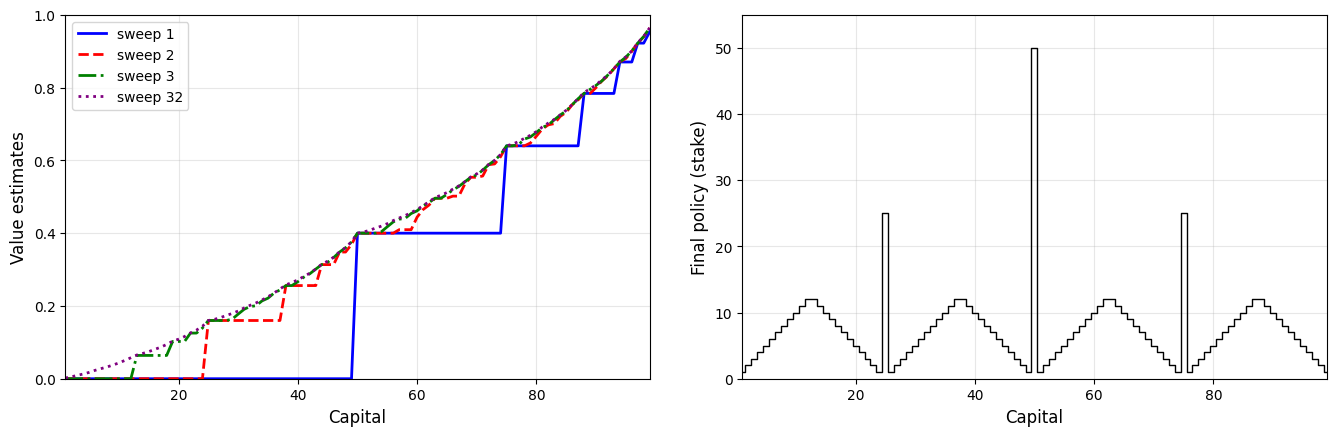

In [266]:
plot_gambler_results(tracked_values, optimal_policy, env)